<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Doubly Robust Learner and Interpretability

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns

# Generating Data

In [3]:
import scipy.special

np.random.seed(123)
n=2000 # number of raw samples
d=10 # number of binary features + 1

# Generating random segments aka binary features. We will use features 0,...,3 for heterogeneity.
# The rest for controls. Just as an example.
X = np.random.binomial(1, .5, size=(n, d))
# Generating an imbalanced A/B test
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# Generating an outcome with treatment effect heterogeneity. The first binary feature creates heterogeneity
# We also have confounding on the first variable. We also have heteroskedastic errors.
y = (-1 + 2 * X[:, 0]) * T + X[:, 0] + (1*X[:, 0] + 1)*np.random.normal(0, 1, size=(n,))
X_test = np.random.binomial(1, .5, size=(10, d))

# Applying the LinearDRLearner

In [4]:
from sklearn.linear_model import LassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=LassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'))
est.fit(y, T, X=X[:, :4])

In [5]:
# Treatment Effect of particular segments
est.effect(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

array([1.02346725])

In [6]:
# Confidence interval for effect. Produces the (alpha*100/2, (1-alpha)*100/2)% Confidence Interval
est.effect_interval(np.array([[1, 0, 0, 0]]), alpha=.05) # effect of segment with features [1, 0, 0, 0]

(array([0.66350818]), array([1.38342633]))

In [7]:
# Other inference for effect, including point estimate, standard error, z score, p value and confidence interval
est.effect_inference(np.array([[1, 0, 0, 0]])).summary_frame(alpha=.05)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,1.023,0.184,5.573,0.0,0.664,1.383


In [8]:
# Getting the coefficients of the linear CATE model together with the corresponding feature names
print(np.array(list(zip(est.cate_feature_names(['A', 'B', 'C', 'D']), est.coef_(T=1)))))
print(est.intercept_(T=1))

[['A' '2.063277038041713']
 ['B' '-0.0021408002029092827']
 ['C' '-0.1307524180853436']
 ['D' '0.08603974866683765']]
-1.0398097870143193


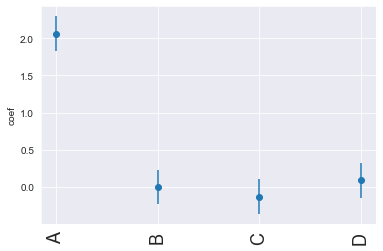

In [9]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

In [10]:
# Getting the inference of the coefficients of the CATE model
# together with the corresponding feature names.
est.coef__inference(T=1).summary_frame(feat_name=['A', 'B', 'C', 'D'])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
A,2.063,0.143,14.431,0.000,1.828,2.298
B,-0.002,0.142,-0.015,0.988,-0.236,0.232
C,-0.131,0.143,-0.916,0.359,-0.365,0.104
D,0.086,0.143,0.603,0.546,-0.149,0.321


In [11]:
# Getting the inference of the intercept of the CATE model
est.intercept__inference(T=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-1.04,0.146,-7.114,0.0,-1.28,-0.799


In [12]:
est.summary(T=1,feat_name=['A', 'B', 'C', 'D'])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
A,2.063,0.143,14.431,0.0,1.828,2.298
B,-0.002,0.142,-0.015,0.988,-0.236,0.232
C,-0.131,0.143,-0.916,0.359,-0.365,0.104
D,0.086,0.143,0.603,0.546,-0.149,0.321
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-1.04,0.146,-7.114,0.0,-1.28,-0.799


### Polynomial Features

In [13]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'),
                      featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
est.fit(y, T, X=X[:, :4])

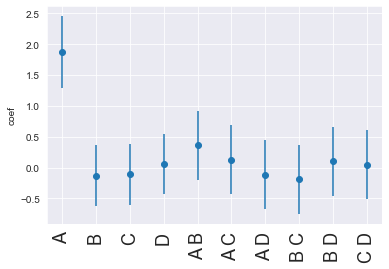

In [14]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

In [15]:
# Getting the inference of the CATE at different X vector values
est.effect_inference(X_test[:,:4]).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,1.192,0.292,4.081,0.000,0.711,1.672
1,-1.057,0.189,-5.585,0.000,-1.368,-0.746
2,1.065,0.253,4.202,0.000,0.648,1.482
3,-1.057,0.189,-5.585,0.000,-1.368,-0.746
4,-1.081,0.177,-6.095,0.000,-1.372,-0.789
5,0.861,0.277,3.107,0.002,0.405,1.318
6,0.926,0.273,3.397,0.001,0.478,1.375
7,-0.892,0.186,-4.784,0.000,-1.199,-0.585
8,0.926,0.273,3.397,0.001,0.478,1.375
9,0.861,0.277,3.107,0.002,0.405,1.318


In [16]:
# Getting the population inference given sample X
est.effect_inference(X_test[:,:4]).population_summary()

### Polynomial Features and Debiased Lasso Inference

In [17]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.drlearner import SparseLinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = SparseLinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'),
                      featurizer=PolynomialFeatures(degree=3, interaction_only=True, include_bias=False))
est.fit(y, T, X=X[:, :4])

#### Parameter Intervals

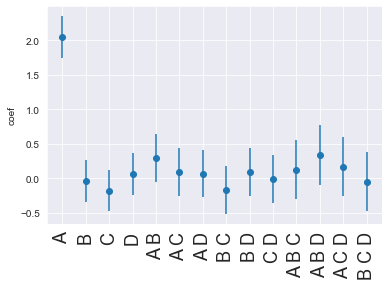

In [18]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

#### CATE(x) intervals

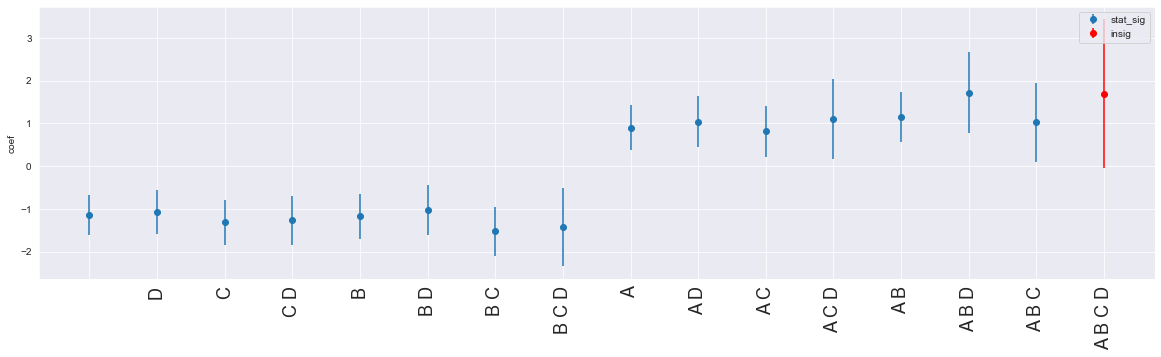

In [19]:
import itertools
# Getting the confidence intervals of the CATE at different X vector values
feat_names = np.array(['A', 'B', 'C', 'D'])
lst = list(itertools.product([0, 1], repeat=4))
point = []
lower = []
upper = []
fnames = []
for x in lst:
    x_test = np.array([x])
    fnames.append(" ".join(np.array(feat_names)[x_test.flatten()>0]))
    point.append(est.effect(x_test)[0])
    lb, ub = est.effect_interval(x_test, alpha=.05)
    lower.append(lb[0])
    upper.append(ub[0])

fnames = np.array(fnames)
point = np.array(point)
lower = np.array(lower)
upper = np.array(upper)
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(20, 5)) 
    x = np.arange(len(point))
    stat_sig = (lower>0) | (upper<0)
    plt.errorbar(x[stat_sig], point[stat_sig], yerr[:, stat_sig], fmt='o', label='stat_sig')
    plt.errorbar(x[~stat_sig], point[~stat_sig], yerr[:, ~stat_sig], fmt='o', color='red', label='insig')
    ax.set_xticks(x)
    ax.set_xticklabels(fnames, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.legend()
    plt.show()

#### CATE(x) inference

In [20]:
# Getting the inference of the CATE at different X vector values
est.effect_inference(X_test[:,:4]).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,1.714,0.484,3.541,0.000,0.918,2.511
1,-1.319,0.268,-4.924,0.000,-1.759,-0.878
2,1.692,0.890,1.901,0.057,0.228,3.156
3,-1.319,0.268,-4.924,0.000,-1.759,-0.878
4,-1.178,0.268,-4.399,0.000,-1.619,-0.738
5,1.035,0.303,3.421,0.001,0.538,1.533
6,1.103,0.476,2.318,0.020,0.320,1.886
7,-1.078,0.267,-4.039,0.000,-1.517,-0.639
8,1.103,0.476,2.318,0.020,0.320,1.886
9,1.035,0.303,3.421,0.001,0.538,1.533


In [21]:
# Getting the population inference given sample X
est.effect_inference(X_test[:,:4]).population_summary()

# Non-Linear Models with Forest CATEs

In [22]:
from econml.drlearner import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor

est = ForestDRLearner(model_regression=GradientBoostingRegressor(),
                      model_propensity=DummyClassifier(strategy='prior'),
                      n_crossfit_splits=5,
                      n_estimators=4000,
                      min_samples_leaf=10,
                      verbose=0, min_weight_fraction_leaf=.01)
est.fit(y, T, X=X[:, :4])

In [23]:
est.feature_importances_(T=1)

array([0.97557292, 0.00818908, 0.00800918, 0.00822882])

#### CATE(x) intervals

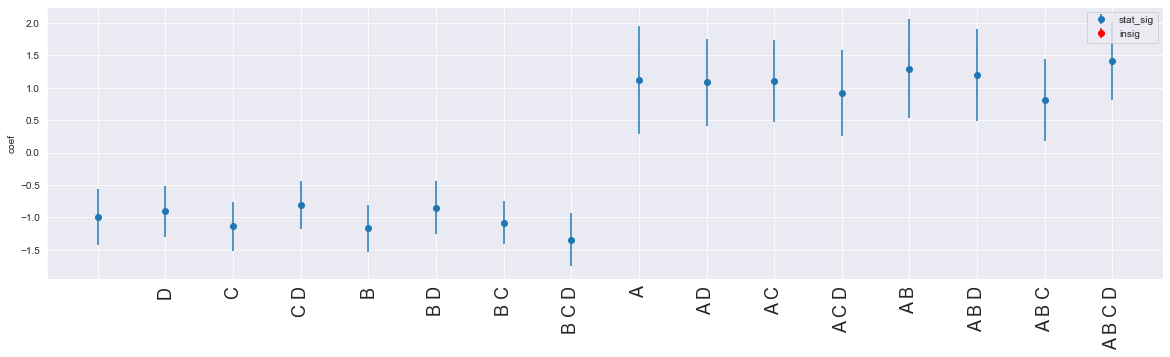

In [24]:
import itertools
# Getting the confidence intervals of the CATE at different X vector values
feat_names = np.array(['A', 'B', 'C', 'D'])
lst = list(itertools.product([0, 1], repeat=4))
point = []
lower = []
upper = []
fnames = []
for x in lst:
    x_test = np.array([x])
    fnames.append(" ".join(np.array(feat_names)[x_test.flatten()>0]))
    point.append(est.effect(x_test)[0])
    lb, ub = est.effect_interval(x_test, alpha=.05)
    lower.append(lb[0])
    upper.append(ub[0])

fnames = np.array(fnames)
point = np.array(point)
lower = np.array(lower)
upper = np.array(upper)
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(20, 5)) 
    x = np.arange(len(point))
    stat_sig = (lower>0) | (upper<0)
    plt.errorbar(x[stat_sig], point[stat_sig], yerr[:, stat_sig], fmt='o', label='stat_sig')
    plt.errorbar(x[~stat_sig], point[~stat_sig], yerr[:, ~stat_sig], fmt='o', color='red', label='insig')
    ax.set_xticks(x)
    ax.set_xticklabels(fnames, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.legend()
    plt.show()

#### CATE(x) inference

In [25]:
# Getting the inference of the CATE at different X vector values
est.effect_inference(X_test[:,:4]).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,1.191,0.361,3.296,0.001,0.597,1.785
1,-1.139,0.192,-5.928,0.000,-1.455,-0.823
2,1.411,0.304,4.637,0.000,0.910,1.911
3,-1.139,0.192,-5.928,0.000,-1.455,-0.823
4,-1.170,0.184,-6.365,0.000,-1.472,-0.868
5,1.082,0.341,3.173,0.002,0.521,1.644
6,0.922,0.340,2.713,0.007,0.363,1.481
7,-0.906,0.202,-4.484,0.000,-1.239,-0.574
8,0.922,0.340,2.713,0.007,0.363,1.481
9,1.082,0.341,3.173,0.002,0.521,1.644


In [26]:
# Getting the population inference given sample X
est.effect_inference(X_test[:,:4]).population_summary()

# Tree Interpretation of the CATE Model

In [27]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [28]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X[:, :4])

In [29]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [30]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_cate_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


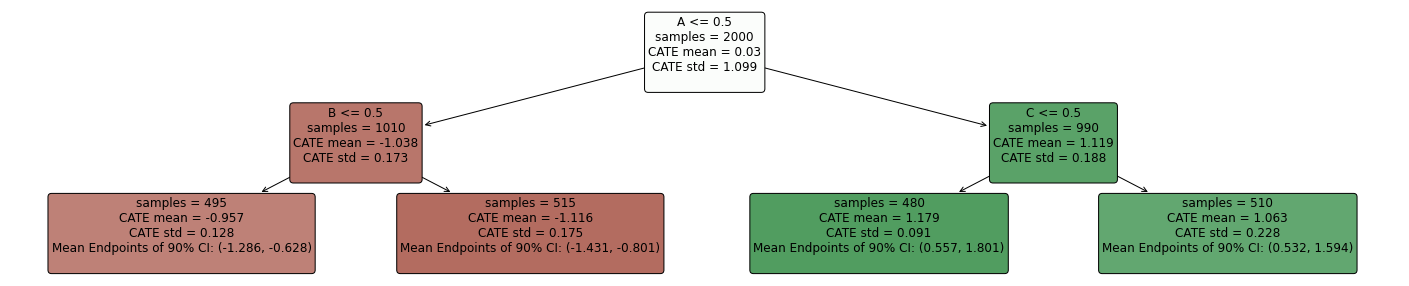

In [31]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Tree Based Treatment Policy Based on CATE Model

In [32]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [33]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=.001)
# We find a tree based treatment policy based on the CATE model
# sample_treatment_costs is the cost of treatment. Policy will treat if effect is above this cost.
# It can also be an array that has a different cost for each sample. In case treating different segments
# has different cost.
intrp.interpret(est, X[:, :4],
                sample_treatment_costs=0.2)

In [34]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [35]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [36]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_policy_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


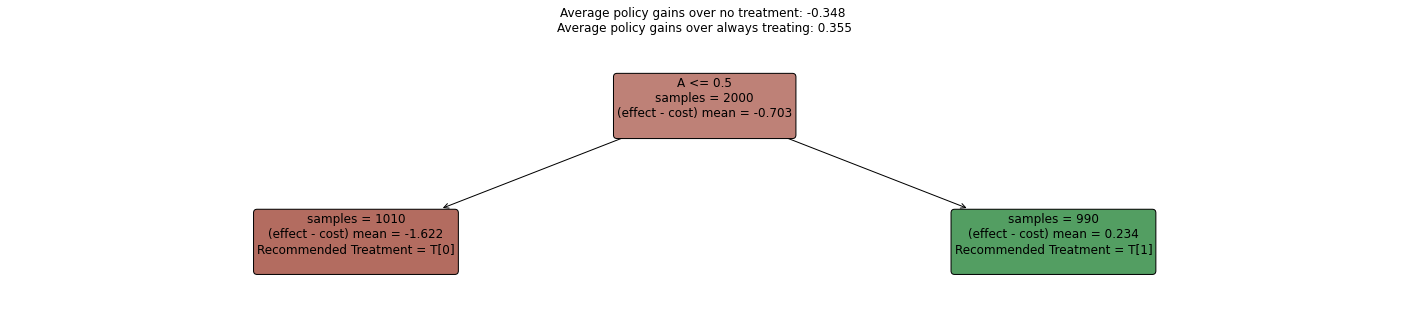

In [37]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# SHAP Interpretability with Final Tree CATE Model

In [38]:
# We need to use a scikit-learn final model
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = DRLearner(model_regression=GradientBoostingRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_propensity=GradientBoostingClassifier(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_final=RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30))
est.fit(y, T, X=X[:, :4], W=X[:, 4:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


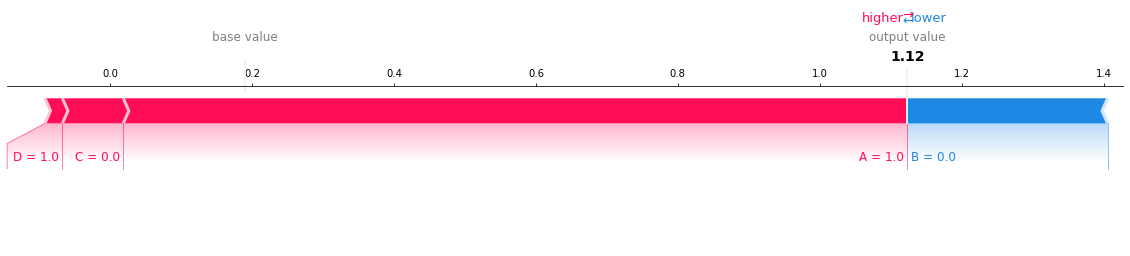

In [39]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X[:, :4], columns=['A', 'B', 'C', 'D'])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(est.model_cate(T=1))
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


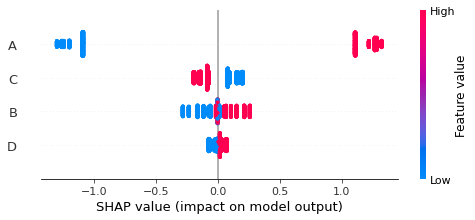

In [40]:
shap.summary_plot(shap_values, Xdf)